# Generating geometric median composites (geomedians) <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[s2a_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2a_ard_granule),
[s2b_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2b_ard_granule)


## Background

Individual remote sensing images can be affected by noisy data, including clouds, cloud shadows, and haze. 
To produce cleaner images that can be compared more easily across time, we can create 'summary' images or 'composites' that combine multiple images into one image to reveal the median or 'typical' appearance of the landscape for a certain time period. 

One approach is to create a [geomedian](https://github.com/daleroberts/hdmedians). 
A `geomedian` is based on a high-dimensional statistic called the 'geometric median' [(Small 1990)](https://www.jstor.org/stable/1403809), which effectively trades a temporal stack of poor quality observations for a single high-quality pixel composite with reduced spatial noise [(Roberts et al. 2017)](https://ieeexplore.ieee.org/abstract/document/8004469). 
In contrast to a standard median, a geomedian maintains the relationship between spectral bands. 
This allows us to conduct further analysis on the composite images just as we would on the original satellite images (e.g by allowing the calculation of common band indices like NDVI).

## Description
In this notebook we will take of time series of noisy satellite images collected over a year and calculate an annual geomedian composite which is largely free of clouds and other noisy data.

Geomedian computations are expensive in terms of memory, data bandwidth, and cpu usage. The ODC has a useful function, [xr_geomedian](https://github.com/opendatacube/odc-tools/blob/master/libs/algo/odc/algo/_geomedian.py) that allows [dask](https://docs.dask.org/en/latest/) to perform the computation in parallel across many threads to speed things up. In this notebook a `local dask cluster` is used, but the same approach should work using a larger, distributed dask cluster.

***


## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages

In [1]:
%matplotlib inline

import numpy as np
import os
import dask
from dask.utils import parse_bytes

import datacube
from datacube.utils.dask import start_local_dask
from odc.algo import to_f32, from_float, xr_geomedian
from datacube.utils.rio import configure_s3_access

import sys
sys.path.append('../Scripts')
from dea_datahandling import load_ard
from dea_plotting import rgb

### Set up a dask cluster

This will help keep our memory use down and conduct the analysis in parallel. If you'd like to view the `dask dashboard`, click on the hyperlink that prints below the cell.


The parameters for generating the local dask cluster are automatically generated, but if you wish to alter them use the documentation [here](https://distributed.dask.org/en/stable/local-cluster.html). Put simply, the code below identifies how many `cpus` and how much `RAM` the computer has and generates a local cluster using those variables. The `if-else` statement in this code block is to help identify whether the notebook is running on the Sandbox or the NCI. 

In [2]:
if 'AWS_ACCESS_KEY_ID' in os.environ:
    # configure dashboard link to go over proxy
    dask.config.set({"distributed.dashboard.link":
                 os.environ.get('JUPYTERHUB_SERVICE_PREFIX', '/')+"proxy/{port}/status"})
    
    # close previous client if any
    client = locals().get('client', None)
    if client is not None:
        client.close()
        del client
    
    # start up a local cluster  
    client = start_local_dask(mem_safety_margin = '3Gb')
    
    ## Configure GDAL for s3 access
    configure_s3_access(aws_unsigned=True,  
                        client=client);
else:
    # close previous client if any
    client = locals().get('client', None)
    if client is not None:
        client.close()
        del client
        
    # start up a local cluster
    client = start_local_dask(mem_safety_margin = '3Gb')

# show the dask cluster settings
display(client)

Client Scheduler: tcp://127.0.0.1:45267 Dashboard: /user/chad/proxy/8787/status,Cluster Workers: 1 Cores: 2 Memory: 14.18 GB


### Connect to the datacube

In [3]:
dc = datacube.Datacube(app='Geomedian_composites')

## Load Sentinel 2 data from the datacube

Here we are loading in a timeseries of cloud-masked Sentinel 2 satellite images through the datacube API using the [load_ard](https://github.com/GeoscienceAustralia/dea-notebooks/blob/develop/Frequently_used_code/Using_load_ard.ipynb) function. 
This will provide us with some data to work with. To limit computation and memory this example uses only three optical bands (red, green, blue).

In [4]:
# Create a query object
query = {
    'x': (153.35, 153.50),
    'y': (-28.85, -29.00),
    'time': ('2017'),
    'measurements': ['nbart_green',
                     'nbart_red',
                     'nbart_blue'],
    'output_crs': 'EPSG:3577',
    'resolution': (-10, 10),
    'group_by': 'solar_day'
}

# Load available data
ds = load_ard(dc=dc, 
              products=['s2a_ard_granule', 's2b_ard_granule'],
              dask_chunks={'x': 1000, 'y':1000},
              **query)

# Print output data
print(ds)


Loading s2a_ard_granule data
    Applying pixel quality/cloud mask
    Applying invalid data mask
    Applying contiguity mask
Loading s2b_ard_granule data
    Applying pixel quality/cloud mask
    Applying invalid data mask
    Applying contiguity mask
Combining and sorting data
    Returning 49 observations as a dask array
<xarray.Dataset>
Dimensions:      (time: 49, x: 1706, y: 1901)
Coordinates:
  * x            (x) float64 2.046e+06 2.046e+06 ... 2.063e+06 2.063e+06
  * y            (y) float64 -3.306e+06 -3.306e+06 ... -3.325e+06 -3.325e+06
  * time         (time) datetime64[ns] 2017-01-01T23:52:42.026000 ... 2017-12-27T23:52:41.026000
Data variables:
    nbart_green  (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    nbart_red    (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    nbart_blue   (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
Attributes:
    crs:      EPSG:3577


## Plot timesteps in true colour

To visualise the data, use the pre-loaded `rgb` utility function to plot a true colour image for a series of timesteps. 
White areas indicate where clouds or other invalid pixels in the image have been masked.

The code below will plot four timesteps of the time series we just loaded.
>Note, this can be quite slow because the dask arrays being plotted must compute first.

In [ ]:
# Set the timesteps to visualise
timesteps = [4, 5, -2, -3]

# Generate RGB plots at each timestep
rgb(ds, index=timesteps)


## Generate a geomedian

As you can see above, most satellite images will have at least some areas masked out due to clouds or other interference between the satellite and the ground. 
Generating a geomedian composite will combine all the observations in our `xarray.Dataset` into a single, complete (or near complete) image representing the geometric median of the time period.  This process requires a couple of steps:

1. Before we calculate the geomedian, we first need to prepare the dataset by scaling the surface reflectance values from their original range to `0-1` (DEA's Sentinel 2 and Landsat archives are both scaled from `0-10,000`).  This will ensure numerical stability during the computation.

2. Call the `xr_geomedian` fucntion.  The parameters in the `xr_geomedian` code block do not usually require changing. The `eps` parameter controls the number of iterations to conduct; a good default is `1e-7`.  After calling the function, we then run `.compute()`, which will trigger the computation.

3. Finally, we will convert the result back to the original scaling values (0-10,000 in this example).

In [5]:
sr_max_value = 10000                 # maximum value for SR in the loaded product
scale, offset = (1/sr_max_value, 0)  # differs per product, aim for 0-1 values in float32

#scale the values using the f_32 util function
ds_scaled = to_f32(ds,
                   scale=scale,
                   offset=offset)

In [6]:
#generate a geomedian
geomedian = xr_geomedian(ds_scaled, 
                         num_threads=1,  # disable internal threading, dask will run several concurrently
                         eps=1e-7,  
                         nocheck=True)   # disable checks inside library that use too much ram


### Run the computation

The `.compute()` method will trigger the computation of everything we've instructed above. This will take about 5 mins to run, view the `dask dashboard` to check the progress.

In [7]:
%%time
geomedian = geomedian.compute()

CPU times: user 17.4 s, sys: 1.21 s, total: 18.6 s
Wall time: 3min 22s


In [8]:
#convert SR scaling values back to original values
geomedian = from_float(geomedian, 
                       dtype='float32', 
                       nodata=np.nan, 
                       scale=1/scale, 
                       offset=-offset/scale)

If we print our result, you will see that the `time dimension` has now been removed and we are left with a single image that represents the geometric median of all the satellite images in our initial time series.

In [9]:
print(geomedian)

<xarray.Dataset>
Dimensions:      (x: 1706, y: 1901)
Coordinates:
  * y            (y) float64 -3.306e+06 -3.306e+06 ... -3.325e+06 -3.325e+06
  * x            (x) float64 2.046e+06 2.046e+06 ... 2.063e+06 2.063e+06
Data variables:
    nbart_green  (y, x) float32 709.8406 707.6732 ... 193.68938 192.43611
    nbart_red    (y, x) float32 726.0006 715.415 ... 104.573586 111.941505
    nbart_blue   (y, x) float32 435.59882 431.1664 ... 269.41306 268.00156


## Plot the geomedian composite

Plotting the result, we can see that the geomedian image is much more complete than any of the individual images. 
We can also use this data in downstream analysis as the relationships between the spectral bands are maintained by the geometric median statistic.

> **Note:** You may notice that there are still some holes in our geomedian composite (white clusters of pixels). 
This is largely due to [Fmask](https://github.com/GERSL/Fmask) (the current default cloud masking algorithm) being overzealous in removing pixels when masking Sentinel 2 satellite images, especially over cities and other bright objects. 
This is a known limitation of our current cloud masking approach and a new method for cloud masking of Sentinel 2 data is currently in development.

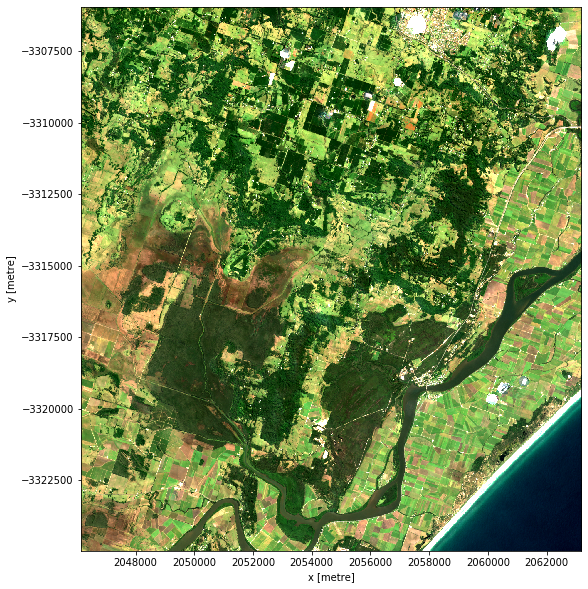

In [10]:
# Plot the result
rgb(geomedian, size=10)


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** December 2019

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)